# 3η Εργαστηριακή Άσκηση
# Link prediction - Πρόβλεψη συνδέσμων

## Imports

In [ ]:
%pip install --upgrade numpy
%pip install --upgrade pandas
%pip install --upgrade networkx
%pip install --upgrade matplotlib
%pip install --upgrade scikit-learn
%pip install --upgrade node2vec

In [1]:
import joblib
import numpy as np
import pandas as pd
import networkx as nx
import multiprocessing
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## 1. Κατασκευή γράφου και προεργασία για την πρόβλεψη συνδέσμων

### 1.1.
Χρησιμοποιήστε το dataset [Similarities (DBpedia)](http://konect.cc/networks/dbpedia-similar/) για να κατασκευάσετε τον μη κατευθυνόμενο (undirected) γράφο $G$ [[1]](https://dl.acm.org/doi/10.1145/2487788.2488173)[[2]](https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52). Οι κόμβοι του γράφου αναπαριστούν σελίδες της Wikipedia και οι ακμές σχέση ομοιότητας μεταξύ τους. Στην σελίδα [KONECT (DBpedia)](http://konect.cc/networks/dbpedia-similar/) μπορείτε να βρείτε πληροφορίες για τις ιδιότητες του γράφου.

***Υπόδειξη:***
Μπορείτε να ελέγξετε προγραμματιστικά αν το dataset περιέχει διπλότυπα των ακμών με την ίδια ή αντίστροφη σειρά (π.χ. ακμές (a,b) και (b,a)), και να λάβετε υπ' όψιν σας αυτήν σας την παρατήρηση, όπου τυχόν χρειαστεί, στην ερώτηση 2.

In [3]:
!wget -q http://konect.cc/files/download.tsv.dbpedia-similar.tar.bz2 -P resources
!tar -xf resources/download.tsv.dbpedia-similar.tar.bz2 -C resources
!mv resources/dbpedia-similar/out.dbpedia-similar resources
!rm -r resources/dbpedia-similar
!rm resources/download.tsv.dbpedia-similar.tar.bz2

In [4]:
edges = set()
duplicates = set()

with open('resources/out.dbpedia-similar', 'r') as f:
    for line in f:
        if line.startswith('%'):
            continue
        else:
            from_node, to_node = map(int, line.split())
            edge = tuple(sorted((from_node, to_node)))
            if edge in edges:
                duplicates.add(edge)
            else:
                edges.add(edge)

if not duplicates:
    print(f"There are no duplicate edges")
else:
    print(f"The following are duplicate edges: {duplicates}")

G = nx.read_edgelist('resources/out.dbpedia-similar', create_using=nx.Graph(), nodetype=int, comments='%')
G.remove_edges_from(nx.selfloop_edges(G))
print(G)

There are no duplicate edges
Graph with 430 nodes and 564 edges


### 1.2.
Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G$.

In [5]:
def get_graph_stats(G):
    nodes_count = G.number_of_nodes()
    edges_count = G.number_of_edges()
    average_degree = 2 * edges_count / nodes_count
    connected_components_count = nx.number_connected_components(G)

    print(f"Nodes count: {nodes_count}")
    print(f"Edges count: {edges_count}")
    print(f"Average degree: {average_degree}")
    print(f"Connected components count: {connected_components_count}")
    
    return nodes_count, edges_count, average_degree, connected_components_count

print(f"- Initial graph stats")
initial_nodes_count, initial_edges_count, initial_average_degree, initial_connected_components_count = get_graph_stats(G)

- Initial graph stats
Nodes count: 430
Edges count: 564
Average degree: 2.6232558139534885
Connected components count: 95


### 1.3.
Υπολογίστε το σύνολο των ασύνδετων ζευγών κόμβων (unconnected pairs) στον γράφο χρησιμοποιώντας τον πίνακα γειτνίασης (adjacency matrix). Δώστε επίσης τον αριθμό τους. Λάβετε υπ' όψιν σας ότι ο γράφος είναι μη κατευθυνόμενος και δεν χρειάζεται να διατρέξετε ολόκληρο τον πίνακα γειτνίασης.

In [6]:
adjacency_matrix = nx.to_numpy_matrix(G)
unconnected_pairs = []

for i in range(adjacency_matrix.shape[0]):
    for j in range(i + 1, adjacency_matrix.shape[1]):
        if adjacency_matrix[i, j] == 0:
            unconnected_pairs.append((i+1, j+1))

print(f"Unconnected pairs count: {len(unconnected_pairs)}")

Unconnected pairs count: 91671


### 1.4.
Υπολογίστε το σύνολο των ακμών (removable edges) που μπορούν να αφαιρεθούν από τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου (δηλ. ο αριθμός των συνεκτικών συνιστωσών θα πρέπει να παραμένει αμετάβλητος). Υπόδειξη: Ελέγχετε επίσης ότι με αφαίρεση ακμής δεν μειώνεται ο αριθμός των κόμβων (εφόσον δεν υπάρχει ξεχωριστό αρχείο μόνο με κόμβους στο dataset). Δώστε επίσης τον αριθμό των ακμών (removable edges) που μπορούν να αφαιρεθούν υπό αυτές τις προϋποθέσεις.

In [7]:
copy = G.copy()
removable_edges = []

for edge in G.edges():
    copy.remove_edge(*edge)
    if nx.number_connected_components(copy) == initial_connected_components_count and copy.number_of_nodes() == initial_nodes_count:
        removable_edges.append(edge)
    else:
        copy.add_edge(*edge)

print(f"Removable edges count: {len(removable_edges)}")

Removable edges count: 229


### 1.5.
a. Κατασκευάστε dataframe που συνενώνει τις απαντήσεις των ερωτημάτων 1.3 και 1.4 (unconnected+removables). Χρησιμοποιήστε την μεταβλητή $link$ που θα παίρνει τιμή 1 ή 0 ανάλογα με την ύπαρξη συνδέσμου ή μη. To dataframe αυτό συγκεντρώνει τα θετικά και αρνητικά δείγματα για την πρόβλεψη των μελλοντικών συνδέσεων (link: target variable).

b. Κατασκευάστε τον γράφο $G'$ που προκύπτει από την αφαίρεση από τον γράφο $G$ των ακμών του ερωτήματος 1.4.

c. Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G'$.

In [8]:
df_edges = unconnected_pairs + removable_edges
df_edges.sort()
df_links = [0 if edge in unconnected_pairs else 1 for edge in df_edges]
df = pd.DataFrame({'edge': df_edges, 'link': df_links})

G_reduced = G.copy()
G_reduced.remove_edges_from(removable_edges)

print(f"- Reduced graph stats")
reduced_nodes_count, reduced_edges_count, reduced_average_degree, reduced_connected_components_count = get_graph_stats(G_reduced)

- Reduced graph stats
Nodes count: 430
Edges count: 335
Average degree: 1.558139534883721
Connected components count: 95


## 2. Εισαγωγή σε similarity-based μετρικές για Link prediction

* Η μετρική **Jaccard Coefficient (JC)** των κόμβων ${u}$ και ${v}$ ορίζεται ως $\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$, όπου ${\Gamma(u)}$ είναι το σύνολο των γειτονικών κόμβων του κόμβου ${u}$.

* Η μετρική **Preferential Αttachment (PA)** των κόμβων $u$ και $v$ ορίζεται ως $|\Gamma(u)| |\Gamma(v)|$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.

* Η μετρική **Resource Allocation (RA)** των κόμβων $u$ και $v$ ορίζεται ως $\sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{|\Gamma(w)|}$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.

### 2.1.
Για τον γράφο $G'$, που κατασκευάσατε στο ερώτημα 1.5.b, υπολογίστε την μετρική **Jaccard Coefficient (JC)**. [Χρησιμοποιήστε την υλοποιημένη συνάρτηση του λογισμικού NetworkX](https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html?highlight=link%20prediction).

In [9]:
jaccard_coefficient = [(u, v, p) for u, v, p in nx.jaccard_coefficient(G_reduced)]

### 2.2.
Δώστε τις $k$ ακμές με την υψηλότερη τιμή μετρικής $JC$, όπου $k$ ο $Α.Μ.$ σας $mod$ $10$. Για $Α.Μ.$ λήγοντα σε $0$ δώστε τις $10$ ακμές με την υψηλότερη τιμή μετρικής.
Για την σύγκριση μεταξύ διαφορετικών μετρικών προτιμάται η εύρεση των $k$ επικρατέστερων συνδέσμων, αφού οι μετρικές επιστρέφουν διαφορετικό εύρος τιμών.

In [10]:
k = 18153 % 10
sorted_jaccard_coefficient = sorted(jaccard_coefficient, key=lambda x: x[2], reverse=True)

print(f"- Top {k} edges with best Jaccard Coefficients:")
for index, triple in enumerate(sorted_jaccard_coefficient[:k]):
    from_node, to_node, jc = triple
    print(f"#{index+1}: Edge from node {from_node} to node {to_node} with a Jaccard Coefficient of {jc}")

- Top 3 edges with best Jaccard Coefficients:
#1: Edge from node 4 to node 46 with a Jaccard Coefficient of 1.0
#2: Edge from node 4 to node 47 with a Jaccard Coefficient of 1.0
#3: Edge from node 4 to node 49 with a Jaccard Coefficient of 1.0


### 2.3.
Προσδιορίστε για την μέτρηση της απόδοσης της μετρικής $JC$ τα μεγέθη $Precision$, $Recall$ και $Accuracy$ και αναπαραστήστε τα γραφικά για τιμές κατωφλίου: $0.1$, $0.15$, $0.25$, $0.5$, $1.0$.

$Precision=\frac{TP}{TP+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα

$Recall=\frac{TP}{TP+FN}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα

$Accuracy=\frac{TP+TN}{TP+FN+TN+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $TN$: αληθώς αρνητικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα

***Υπόδειξη:***
* Θετικό θεωρήστε ένα αποτέλεσμα, αν η μετρική $JC$ υπερβαίνει μια τιμή κατωφλίου (>=). Αρνητικό θεωρήστε το στην αντίθετη περίπτωση.
* Αληθώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά (η τιμή της $JC$ υπερβαίνει την τιμή κατωφλίου) και πράγματι θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1.4).
* Αληθώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά και πράγματι δεν θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1.3).
* Ψευδώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά, ενώ δεν θα υπάρξουν οι συνδέσεις που περιγράφουν.
* Ψευδώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά, ενώ θα υπάρξουν οι συνδέσεις που περιγράφουν.
* Το άθροισμα $TN+FP$ πρέπει κάθε φορά να σας δίνει όλες τις ασύνδετες ακμές του γράφου $G$.
* Από το ερώτημα 1.3 οι ακμές που υπολογίσατε είναι αυτές για τις οποίες δεν θα υπάρξουν συνδέσεις.
* Από το ερώτημα 1.4 οι ακμές που υπολογίσατε είναι αυτές για τις οποίες θα υπάρξουν συνδέσεις.

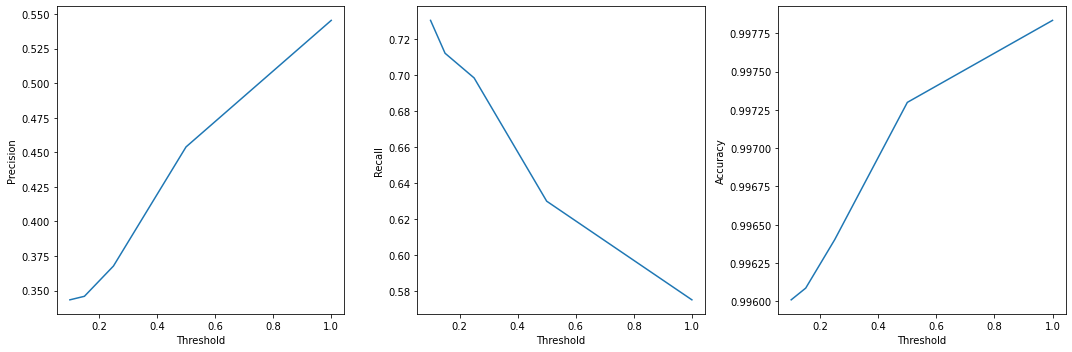

In [20]:
thresholds = [0.1, 0.15, 0.25, 0.5, 1.0]

def JC_function(threshold):
    TP, FP, FN, TN = 0, 0, 0, 0
    
    for edge in jaccard_coefficient:
        from_node, to_node, jc = edge

        if jc >= threshold:
            if (from_node, to_node) in removable_edges:
                TP += 1
            elif (from_node, to_node) in unconnected_pairs:
                FP += 1

        elif jc < threshold:
            if (from_node, to_node) in removable_edges:
                FN += 1
            elif (from_node, to_node) in unconnected_pairs:
                TN += 1
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / (TP + FP + FN + TN)

    return precision, recall, accuracy

precisions, recalls, accuracies = [], [], []

for threshold in thresholds:
    precision, recall, accuracy = JC_function(threshold)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
data = zip([ax1, ax2, ax3],
           [precisions, recalls, accuracies],
           ['Precision', 'Recall', 'Accuracy'])

for ax, metric, title in data:
    ax.plot(thresholds, metric)
    ax.set_xlabel('Threshold')
    ax.set_ylabel(title)
plt.tight_layout()
plt.show()

## 3. Πρόβλεψη συνδέσμων βάσει similarity-based μετρικών

### 3.1.
Προτείνετε μια τουλάχιστον μέθοδο, για να εξερευνήσουμε και να εκφράσουμε μέσα από τα πακέτα NumPy ή SciPy ή Pandas την συσχέτιση (correlation) μεταξύ των τιμών των μετρικών **Jaccard Coefficient**, **Preferential Attachment**, **Resource Allocation** για τον μειωμένο γράφο $G'$. 

***Σημείωση***: Δεν χρειάζεται κάποια υλοποίηση, μόνο αναφορά της μεθόδου συσχέτισης και επεξήγηση της επιλογής σας.

### 3.2.
Εργαστείτε πάνω σε **αντίγραφο** του dataframe που κατασκευάσατε στο ερώτημα 1.5.a (unconnected+removables). Δημιουργήστε στήλη (column) με τις ακμές του γράφου και θέστε την ως index του dataframe. Στο dataframe θα προσθέσετε ως στήλες τις τιμές των μετρικών (**Jaccard Coefficient**, **Preferential Attachment**, **Resource Allocation**) για τον μειωμένο γράφο $G'$. Οι τιμές των μετρικών μπορούν να υπολογιστούν με τις συναρτήσεις του πακέτου NetworkX.

|       | link  |Jacc.Coeff.|Pr.Attachment| Resource Allocation|
|-------|-------|-----------|-------------|--------------------|
|(1, 6) |  0    |  0.333333 |     32      |    0.700000        |
|(1, 46)|  0    |  0.200000 |      8      |    0.166667        |

In [11]:
df_copy = df.copy()
df_copy.set_index('edge', inplace=True)

jaccard_coefficient = [p for u, v, p in nx.jaccard_coefficient(G_reduced)]
preferential_attachment = [p for u, v, p in nx.preferential_attachment(G_reduced)]
resource_allocation = [p for u, v, p in nx.resource_allocation_index(G_reduced)]

df_copy = df_copy.assign(jaccard_coefficient=jaccard_coefficient, preferential_attachment=preferential_attachment, resource_allocation=resource_allocation)

In [12]:
df_copy

,link,jaccard_coefficient,preferential_attachment,resource_allocation
edge,,,,
"(1, 2)",1,0.0,1,0.0
"(1, 3)",1,0.0,2,0.0
"(1, 4)",1,0.0,1,0.0
"(1, 6)",0,0.0,7,0.0
"(1, 7)",0,0.0,1,0.0
...,...,...,...,...
"(426, 430)",0,0.0,1,0.0
"(427, 428)",0,0.0,2,0.0
"(427, 429)",0,0.0,1,0.0


### 3.3.
a. Χρησιμοποιήστε τον Random Forest Classifier και το αντίγραφο dataframe που κατασκευάσατε στο ερώτημα 3.2, για να προβλέψετε συνδέσεις. Συμπληρώστε στον κώδικα: τα features ($X$), την target variable ($y$) και τα ορίσματα της συνάρτησης $fit$ για το training του μοντέλου.

b. Δώστε τις ($A.M$ $mod$ $10$) πρώτες προβλέψεις και την ακρίβεια ($accuracy$) του μοντέλου.

c. Υπολογίστε την πιθανότητα να συνδεθούν οι κόμβοι ($1$,$47$) βάσει του μοντέλου σας.

In [13]:
X = df_copy[['jaccard_coefficient', 'preferential_attachment', 'resource_allocation']]
y = df_copy['link']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [14]:
classifier = RandomForestClassifier()

mm_scaler = MinMaxScaler()
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

parameters = {'n_estimators' : [10, 50, 100], 'max_depth' : [5, 10, 15]}
model = GridSearchCV(classifier, param_grid = parameters)

In [15]:
model.fit(X_train_scaled, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 50, 100]})

In [16]:
y_pred = model.predict(X_test_scaled)

print(f"- First {k} predictions:")
for index, prediction in enumerate(y_pred[:k]):
    print(f"#{index+1}: {prediction}")

print(f"\n- Accuracy: {accuracy_score(y_test, y_pred)}")

- First 3 predictions:
#1: 0
#2: 0
#3: 0

- Accuracy: 0.9996082698585419


In [17]:
edge = df_copy.loc[[(1, 47)]]
x_edge = edge[['jaccard_coefficient', 'preferential_attachment', 'resource_allocation']]
scaled_x_edge = mm_scaler.transform(x_edge)
probability = model.predict_proba(scaled_x_edge)

print(f"Probability of edge (1, 47) being a link: {probability[0][1]}")

Probability of edge (1, 47) being a link: 0.00042690410759662543


## 4. Πρόβλεψη συνδέσμων με embedding βασισμένο σε τυχαίους περιπάτους (Random Walks)

### 4.1.
Εξάγετε τα χαρακτηριστικά (features) του γράφου $G'$, που προέκυψε από την αφαίρεση των ακμών. Για τον σκοπό αυτό χρησιμοποιήστε τον αλγόριθμο **Node2vec** [[3]](https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf). Ο αλγόριθμος αντιστοιχίζει τους κόμβους του γράφου μέσω τυχαίων περιπάτων (biased 2nd order random walks) σε ένα χώρο μικρού αριθμού διαστάσεων (low dimensional space) διατηρώντας την μεταξύ τους γειτνίαση.

Για την επιλογή των παραμέτρων:
* p - παράμετρος τυχαίων περιπάτων p που καθορίζει την πιθανότητα “1/p” επιστροφής στον κόμβο προέλευσης (source node),
* q - παράμετρος τυχαίων περιπάτων q που καθορίζει την πιθανότητα  “1/q” μετακίνησης σε κόμβο μακριά από τον κόμβο προέλευσης (source node),
* dimensions - πλήθος διαστάσεων των Node2Vec embeddings,
* num_walks - αριθμός περιπάτων από κάθε κόμβο,
* walk_length - μήκος τυχαίου περιπάτου,
* window_size - μέγεθος παραθύρου context για τον αλγόριθμο Word2Vec,
* num_iter - αριθμός SGD επαναλήψεων (epochs),
* workers - αριθμός workers για τον Word2Vec,

χρησιμοποιήστε τις τιμές:

|   p   |   q   | dimensions|  num_walks  |walk_length |window_size|          workers          |
|-------|-------|-----------|-------------|------------|-----------|---------------------------|
|  1.0  |  1.0  |  128      |     10      |    80      |     10    |multiprocessing.cpu_count()|

In [18]:
node2vec_walker = Node2Vec(
    G_reduced, 
    p=1.0, 
    q=1.0, 
    dimensions=128, 
    num_walks=10, 
    walk_length=80, 
    workers=multiprocessing.cpu_count())

n2v_model = node2vec_walker.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/430 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


### 4.2.
Εφαρμόστε τον αλγόριθμο Random Forest Classifier, για να προβλέψετε τις συνδέσεις.

In [19]:
X = [(n2v_model.wv[str(i)] + n2v_model.wv[str(j)]) for i, j in df['edge']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

### 4.3.
Υπολογίστε την ακρίβεια ($accuracy$) του μοντέλου.

In [20]:
y_pred = classifier.predict(X_test)
print(f"- Accuracy: {accuracy_score(y_test, y_pred)}")

- Accuracy: 0.9994776931447226


### Bonus Question (+10/100)
Για τους binary operators για learning των edge features με τον αλγόριθμο Node2Vec που αναφέρονται στο [[3]](https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf), δηλαδή τους (a) Average, (b) Hadamard, (c) Weighted-L1 και (d) Weighted-L2 τροποποιήστε τoν κώδικά σας και σημειώστε τις παρατηρήσεις σας ως προς την απόδοση του αλγορίθμου.

In [21]:
X_average = [(n2v_model.wv[str(i)] + n2v_model.wv[str(j)]) / 2 for i, j in df['edge']]
X_hadamard = [(n2v_model.wv[str(i)] * n2v_model.wv[str(j)]) for i, j in df['edge']]
X_l1 = [np.abs(n2v_model.wv[str(i)] - n2v_model.wv[str(j)]) for i, j in df['edge']]
X_l2 = [(n2v_model.wv[str(i)] - n2v_model.wv[str(j)]) ** 2 for i, j in df['edge']]

accuracies = []

for x in [X_average, X_hadamard, X_l1, X_l2]:
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
    classifier = RandomForestClassifier(max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

operators = ['Average', 'Hadamard', 'Weighted-L1', 'Weighted-L2']
for operator, accuracy in zip(operators, accuracies):
    print(f"- Accuracy for {operator} operator: {accuracy}")

- Accuracy for Average operator: 0.9994776931447226
- Accuracy for Hadamard operator: 0.9994341675734494
- Accuracy for Weighted-L1 operator: 0.9994341675734494
- Accuracy for Weighted-L2 operator: 0.9994341675734494


We can see that the accuracy of the algorithm stays the same and is almost perfect, with a value of 99.94%, no matter the operator used. Furthermore, this accuracy is the same as the one achieved by the given operator (simple addition).

## Βιβλιογραφία
[[1]Jérôme Kunegis. KONECT – The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343–1350, 2013.](https://dl.acm.org/doi/10.1145/2487788.2488173)

[[2]Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, and Zachary Ives. DBpedia: A nucleus for a web of open data. In Proc. Int. Semant. Web Conf., pages 722–735, 2008.](https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52)

[[3]A. Grover, J. Leskovec, Node2vec: Scalable Feature Learning for Networks. ACM KDD, 2016.](https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf)

[[4]T.Mikolov, I.Sutskever, K.Chen, G.S.Corrado and J.Dean, Distributed representations of words and phrases and their compositionality. In NIPS, 2013.](https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)